In [1]:
import pandas as pd
import numpy as np
from d2l import torch as d2l


def data_split(data_path, x=0.9, random=False):
    """
    切分数据集和验证集，默认数据集和验证集比例为 9:1
    """
    print("Split data ...")
    timer = d2l.Timer()
    timer.start()
    f = open(data_path, 'r')
    temp = []
    while True:
        line = f.readline()
        if line == '':
            break
        user, num = line.split('|')
        for i in range(int(num)):
            line = f.readline()
            item, rating = line.split('  ')
            temp.append([int(user), int(item), int(rating)])

    ratings = pd.DataFrame(temp)
    ratings.rename(columns={0: 'uid', 1: 'iid', 2: 'rating'}, inplace=True)
    validation_index = []
    for uid in ratings.groupby("uid").any().index:
        user_rating_data = ratings.where(ratings["uid"] == uid).dropna()
        if random:
            index = list(user_rating_data.index)
            np.random.shuffle(index)
            _index = round(len(user_rating_data) * x)
            validation_index += list(index[_index:])
        else:
            index = round(len(user_rating_data) * x)
            validation_index += list(user_rating_data.index.values[index:])

    validation_set = ratings.loc[validation_index]
    train_set = ratings.drop(validation_index)
    timer.stop()
    print('Takes :{} sec'.format(timer.sum()))
    return train_set, validation_set

In [2]:
import pandas as pd
from d2l import torch as d2l


def read_att(attribute_path):
    """
    读取 itemAttribute.txt 文件，将item与Attribute以键值对的形式保存到字典
    """
    f = open(attribute_path, 'r')
    pre_att = {}
    while True:
        line = f.readline()
        if line == '':
            break
        item, att1, att2 = line.split('|')
        pre_att[item] = (att1, att2[:-1])
    return pre_att


def get_att(data_path, att, index):
    """
    获取 user 与 Attribute 的对应关系，若有多个则取其均值
    """
    print("Attribute processing ...")
    timer = d2l.Timer()
    timer.start()
    f = open(data_path, 'r')
    attribute = pd.DataFrame(columns=['uid', 'iid', 'rating'], dtype=float)
    while True:
        line = f.readline()
        if line == '':
            break
        user, num = line.split('|')
        group = pd.DataFrame(columns=['iid', 'rating'], dtype=float)
        for i in range(int(num)):
            line = f.readline()
            item, rating = line.split('  ')
            if item in att.keys() and att[item][index] != 'None':
                temp = pd.DataFrame([[int(att[item][index]), int(rating)]], columns=['iid', 'rating'])
                group = group.append(temp)
        if group.empty:
            continue
        group = group.groupby('iid').mean().reset_index()
        group['uid'] = int(user)
        attribute = attribute.append(group[['uid', 'iid', 'rating']], ignore_index=True)
    timer.stop()
    print('Takes :{} sec'.format(timer.sum()))
    return attribute

In [3]:
train_path = 'data-202205/train.txt'
test_path = 'data-202205/test.txt'
attribute_path = 'data-202205/itemAttribute.txt'
answer_path = 'answer.txt'
# 训练轮数
epochs = 15
columns = ['uid', 'iid', 'rating']
# 两个模型，共两个训练集和两个验证集，
train1, validation1 = data_split(train_path, x=0.9, random=True)
train2, validation2 = data_split(train_path, x=0.9, random=True)
# 属性1和属性2
pre_attribute = read_att(attribute_path)
attribute1 = get_att(train_path, pre_attribute, 0)
attribute2 = get_att(train_path, pre_attribute, 1)

Split data ...
Takes :6233.9932062625885 sec
Split data ...
Takes :6369.123396873474 sec
Attribute processing ...
Takes :1174.5516879558563 sec
Attribute processing ...
Takes :1108.5809533596039 sec


In [11]:
class BiasSvd:
    """
    BiasSvd 算法实现
    """

    def __init__(self, dataset, alpha, hidden, parameter_p, parameter_q, parameter_bu, parameter_bi):
        """
        :param dataset: 训练此模型使用的数据集
        :param alpha: 学习率
        :param hidden: 隐藏层维度
        :param parameter_p: 正则系数
        :param parameter_q: 正则系数
        :param parameter_bu: user偏置
        :param parameter_bi: item偏置
        """
        self.dataset = dataset
        self.alpha = alpha
        self.hidden = hidden
        self.parameter_p = parameter_p
        self.parameter_q = parameter_q
        self.parameter_bu = parameter_bu
        self.parameter_bi = parameter_bi
        self.users_ratings = dataset.groupby(columns[0]).agg([list])[[columns[1], columns[2]]]
        self.items_ratings = dataset.groupby(columns[1]).agg([list])[[columns[0], columns[2]]]
        self.global_mean = self.dataset[columns[2]].mean()
        self.bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        self.bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))
        self.P = dict(zip(
            self.users_ratings.index,
            np.random.rand(len(self.users_ratings), self.hidden).astype(np.float32)
        ))
        self.Q = dict(zip(
            self.items_ratings.index,
            np.random.rand(len(self.items_ratings), self.hidden).astype(np.float32)
        ))


class Baseline:
    """
    Baseline 算法实现
    """

    def __init__(self, dataset, parameter_bu, parameter_bi):
        """

        :param dataset: 训练此模型使用的数据集
        :param parameter_bu: user偏置
        :param parameter_bi: item偏置
        """
        self.dataset = dataset
        self.parameter_bu = parameter_bu
        self.parameter_bi = parameter_bi
        self.users_ratings = dataset.groupby(columns[0]).agg([list])[[columns[1], columns[2]]]
        self.items_ratings = dataset.groupby(columns[1]).agg([list])[[columns[0], columns[2]]]
        self.global_mean = self.dataset[columns[2]].mean()
        self.bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        self.bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))


def train(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, val1, val2, val=False):
    """
    :param bl_cf: 待训练的 baseline
    :param bs_cf: 待训练的 biassvd
    :param bl_att1: attribute1 的 baseline 模型
    :param bs_att1: attribute1 的 biassvd 模型
    :param bl_att2: attribute2 的 baseline 模型
    :param bs_att2: attribute2 的 biassvd 模型
    :param pre_att: item 对应的 attribute 字典
    :param val1: 验证集1
    :param val2: 验证集2
    :param val: 是否需要验证
    :return:
    """
    if val:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 40],
                                legend=['rmse', 'mae'])
        print('Training start')
    else:
        print('Attribute training start')
    timer = d2l.Timer()
    for epoch in range(epochs):
        timer.start()
        # 交替最小二乘法优化 baseline 模型
        for iid, uids, ratings in bl_cf.items_ratings.itertuples(index=True):
            _sum = 0
            for uid, rating in zip(uids, ratings):
                _sum += rating - bl_cf.global_mean - bl_cf.bu[uid]
            bl_cf.bi[iid] = _sum / (bl_cf.parameter_bi + len(uids))

        for uid, iids, ratings in bl_cf.users_ratings.itertuples(index=True):
            _sum = 0
            for iid, rating in zip(iids, ratings):
                _sum += rating - bl_cf.global_mean - bl_cf.bi[iid]
            bl_cf.bu[uid] = _sum / (bl_cf.parameter_bu + len(iids))

        # 随机梯度下降法优化 biassvd 模型
        for i, (uid, iid, real_rating) in enumerate(bs_cf.dataset.itertuples(index=False)):
            vec_pu = bs_cf.P[uid]
            vec_qi = bs_cf.Q[iid]
            error = np.float32(
                real_rating - (bs_cf.global_mean + bs_cf.bu[uid] + bs_cf.bi[iid] + np.dot(vec_pu, vec_qi)))
            vec_pu += bs_cf.alpha * (error * vec_qi - bs_cf.parameter_p * vec_pu)
            vec_qi += bs_cf.alpha * (error * vec_pu - bs_cf.parameter_q * vec_qi)
            bs_cf.P[uid] = vec_pu
            bs_cf.Q[iid] = vec_qi
            bs_cf.bu[uid] += bs_cf.alpha * (error - bs_cf.parameter_bu * bs_cf.bu[uid])
            bs_cf.bi[iid] += bs_cf.alpha * (error - bs_cf.parameter_bi * bs_cf.bi[iid])
        timer.stop()
        # 当需要验证的时候 val 为 True, 执行下面函数
        if val:
            bl_result = validate(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, val1)
            bs_result = validate(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, val2)
            rmse, mae = evaluate_accuracy(bl_result, bs_result)
            animator.add(epoch + 1, (rmse, mae))
            print(rmse, mae)
            #d2l.plt.show()
    if val:
        print('Training time :{}'.format(timer.sum()))
    else:
        print('Attribute training time :{}'.format(timer.sum()))


def validate(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, val):
    """
    验证模型，返回其预测值和真实值
    """
    for uid, iid, real_rating in val.itertuples(index=False):
        pred_rating = predict(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, uid, iid)
        yield uid, iid, real_rating, pred_rating


def predict(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, uid, iid):
    """
    预测电影平分，由 item 和 attribute 的混合模型预测值加权取得
    """
    item_rating = cal_rating(bl_cf, bs_cf, uid, iid)
    if str(iid) in pre_att.keys():
        att1_rating = cal_rating(bl_att1, bs_att1, uid, pre_att[str(iid)][0])
        att2_rating = cal_rating(bl_att2, bs_att2, uid, pre_att[str(iid)][1])
    else:
        att1_rating = item_rating
        att2_rating = item_rating
    predict_rating = 0.8 * item_rating + 0.1 * att1_rating + 0.1 * att2_rating
    return predict_rating


def cal_rating(bl_cf, bs_cf, uid, iid):
    """
    给定 uid, iid 求得 Basiline 和 BiasSvd 模型的预测分数
    """
    if iid not in bl_cf.items_ratings.index:
        bl_pre = bl_cf.global_mean
    else:
        bl_pre = bl_cf.global_mean + bl_cf.bu[uid] + bl_cf.bi[iid]
    if uid not in bs_cf.users_ratings.index or iid not in bs_cf.items_ratings.index:
        bs_pre = bs_cf.global_mean
    else:
        bs_pre = bs_cf.global_mean + bs_cf.bu[uid] + bs_cf.bi[iid] + np.dot(bs_cf.P[uid], bs_cf.Q[iid])
    # 预测结果由 Basiline 和 BiasSvd 取均值获得
    predict_rating = (bl_pre + bs_pre) / 2
    if predict_rating > 100:
        predict_rating = 100
    if predict_rating < 0:
        predict_rating = 0
    return predict_rating


def evaluate_accuracy(bl_pred, bs_pred):
    """
    求得模型的 rmse 和 mae
    """
    metric = d2l.Accumulator(3)
    # Baseline 模型的误差
    for uid, iid, real_rating, pred_rating in bl_pred:
        metric.add(1, (pred_rating - real_rating) ** 2, abs(pred_rating - real_rating))
    # BiasSvd 模型的误差
    for uid, iid, real_rating, pred_rating in bs_pred:
        metric.add(1, (pred_rating - real_rating) ** 2, abs(pred_rating - real_rating))
    return round(np.sqrt(metric[1] / metric[0]), 4), round(metric[2] / metric[0], 4)


def predict_test(file_path, write_path, bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att):
    """
    将对 test.txt 文件的预测结果写入新文件并保存
    """
    f = open(file_path, 'r')
    b = open(write_path, 'w')
    while True:
        line = f.readline()
        if line == '':
            break
        b.write(line)
        user, num = line.split('|')
        for i in range(int(num)):
            line = f.readline().split('\n')[0]
            rating = predict(bl_cf, bs_cf, bl_att1, bs_att1, bl_att2, bs_att2, pre_att, int(user), int(line))
            b.write(line + '  ' + str(rating) + '\n')

22.0979 16.8197
Training time :1344.3884267807007


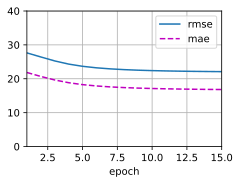

In [9]:
# 模型定义
bl_item = Baseline(train1, 0.1, 0.1)
bs_item = BiasSvd(train2, 0.0006, 120, 0.1, 0.1, 0.1, 0.1)
bl_attribute1 = Baseline(attribute1, 0.05, 0.05)
bs_attribute1 = BiasSvd(attribute1, 0.0005, 50, 0.05, 0.05, 0.05, 0.05)
bl_attribute2 = Baseline(attribute2, 0.05, 0.05)
bs_attribute2 = BiasSvd(attribute2, 0.0005, 50, 0.05, 0.05, 0.05, 0.05)
train(bl_attribute1, bs_attribute1, None, None, None, None, pre_attribute, validation1, validation2, False)
train(bl_attribute2, bs_attribute2, None, None, None, None, pre_attribute, validation1, validation2, False)
train(bl_item, bs_item, bl_attribute1, bs_attribute1, bl_attribute2, bs_attribute2, pre_attribute, validation1,
      validation2, True)
predict_test(test_path, answer_path, bl_item, bs_item, bl_attribute1, bs_attribute1, bl_attribute2, bs_attribute2,
             pre_attribute, )